First I grab the data for all sessions for a single mouse

In [3]:
os.chdir(r'C:\Users\chris\int-brain-lab\wfield\wfield')

In [239]:
## Try to predict which side the stim is on from whole brain trials

from labcams import parse_cam_log
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from  wfield import *
import imageio
import math
from matplotlib import cm
import matplotlib.colors as mplc
from matplotlib.lines import Line2D
import matplotlib as mpl
import seaborn as sns
from analyses import *
from sklearn.linear_model import LogisticRegression
from scipy import stats 

subject = 'CSK-im-002'
baseDir = r'F:\imaging_data'
os.chdir(pjoin(baseDir,subject))
dates = os.listdir()
## iterate through dates for each subject
date = '2021-01-27'
area_activities = []
X_svt_list = []
U_list = []
con_list = []
y_list = []
stim_ons = []
perf_list = []
block_sides = []
for idx,date in tqdm(enumerate(dates[:-1])):
    os.chdir(pjoin(baseDir,subject))
    localdisk = pjoin(os.getcwd(),date)
    os.chdir(localdisk)

    ## Check if the session has been preprocessed, and if behavior data has been downloaded
    if not os.path.isfile('SVTcorr.npy'):
        print('{} \nThis session has not yet been preprocessed, skipping'.format(localdisk))
        continue
    alf_folder = pjoin('G:\\FlatIron\\zadorlab\\Subjects\\',subject,date,'001','alf')
    if not os.path.isfile(pjoin(alf_folder,'_ibl_trials.stimOn_times.npy')):
        print('{} \nNo alf data, try running fetchONE to get it, or check extraction'.format(alf_folder))
        continue
    
    behavior = fetch_task_data(subject,date)
    behavior = behavior[behavior['choice']!=0].reset_index() #drop trials where there was no response
    U = np.load(pjoin(localdisk,'U.npy'))# load spatial components
    SVTcorr = np.load(pjoin(localdisk,'SVTcorr.npy'))# load hemodynamic corrected temporal components
    SVT = SVTcorr# load  normal temporal components
    onset_times = extract_onset_times(localdisk)

    # the allen atlas and brain mask for finding which pixels corresponds to which area
    atlas, area_names, brain_mask = atlas_from_landmarks_file(pjoin(localdisk,'dorsal_cortex_landmarks.JSON'))
    ccf_regions,proj,brain_outline = allen_load_reference('dorsal_cortex')

    #the transform to apply to the images
    transform = load_allen_landmarks(pjoin(localdisk, 'dorsal_cortex_landmarks.JSON'))['transform']
    outline_im, outline = make_allen_outline(atlas, allen_transform=transform)
    lmarks = load_allen_landmarks(pjoin(localdisk, 'dorsal_cortex_landmarks.JSON'))
    nref_regions = allen_transform_regions(None,ccf_regions,
                                    resolution=lmarks['resolution'],
                                    bregma_offset=lmarks['bregma_offset'])
            
    stack = SVDStack(U,SVTcorr)
    stack.set_warped(True,M = lmarks['transform'])
    # mask the pixels outside of the brain outline.
    from wfield.imutils import mask_to_3d
    # transform the brain outline to image coordinates
    b_outline = brain_outline/lmarks['resolution'] + np.array(lmarks['bregma_offset'])
    mask = contour_to_mask(*b_outline.T,dims = U.shape[:-1])
    #create a 3d mask of the brain outline
    mask3d = mask_to_3d(mask,shape = np.roll(stack.U_warped.shape,1))
    # set pixels outside the brain outline to zero
    stack.U_warped[~mask3d.transpose([1,2,0])] = 0   

    #sync up the behavior and grab a few things for analysis
    sync_behavior = sync_to_task(localdisk)
    mask = ['times' in key for key in behavior.keys()]
    time_df = behavior[behavior.keys()[mask]]
    frame_df = pd.DataFrame(columns=time_df.keys())
    for (columnName, columnData) in time_df.iteritems():
        frame_df[columnName] = time_to_frames(sync_behavior,localdisk,np.array(columnData),dropna=False)
    frame_df = frame_df.astype(np.int64)

    stimOn_frames = np.array(frame_df['stimOn_times'])
    block_side = np.array(behavior['probabilityLeft'])
    pre = 5
    post = 15
    X_svt = np.empty((len(stimOn_frames),200,pre+post))
    for i,frame in enumerate(stimOn_frames):
        X_svt[i,:] = SVTcorr[:,frame-pre:frame+post]
    y = np.sign(behavior['signedContrast'])#np.sign(behavior['signedContrast'])
    perf = np.array(behavior['feedbackType'])
    cons = behavior['signedContrast']
    y=np.array(y)
    cons = np.array(cons)
    
    y[y==-1]=0

    X_svt_list.append(X_svt)
    con_list.append(cons)
    y_list.append(y)
    perf_list.append(perf)
    U_list.append(stack.U_warped)
    stim_ons.append(stimOn_frames)
    block_sides.append(block_side)
    unique_areas =np.unique(atlas)

0it [00:00, ?it/s]C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contrastRight'][np.isnan(df['contrastRight'])] = 0
C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contrastLeft'][np.isnan(df['contrastLeft'])] = 0


N pulses: 3033


C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_times['frame']=(onset_times['frame']/2).astype(int)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

N pulses: 2703


C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_times['frame']=(onset_times['frame']/2).astype(int)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

N pulses: 3412


C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_times['frame']=(onset_times['frame']/2).astype(int)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

N pulses: 2573


C:\Users\chris\int-brain-lab\wfield\wfield\analyses.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_times['frame']=(onset_times['frame']/2).astype(int)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\chris\Anaconda3\envs\wfield\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

G:\FlatIron\zadorlab\Subjects\CSK-im-002\2021-01-18\001\alf 
No alf data, try running fetchONE to get it, or check extraction
F:\imaging_data\CSK-im-002\2021-01-19 
This session has not yet been preprocessed, skipping
G:\FlatIron\zadorlab\Subjects\CSK-im-002\2021-01-20\001\alf 
No alf data, try running fetchONE to get it, or check extraction
G:\FlatIron\zadorlab\Subjects\CSK-im-002\2021-01-22\001\alf 
No alf data, try running fetchONE to get it, or check extraction
F:\imaging_data\CSK-im-002\2021-01-26 
This session has not yet been preprocessed, skipping
F:\imaging_data\CSK-im-002\2021-01-28 
This session has not yet been preprocessed, skipping
G:\FlatIron\zadorlab\Subjects\CSK-im-002\2021-01-29\001\alf 
No alf data, try running fetchONE to get it, or check extraction


11it [01:47,  9.74s/it]


In [240]:
## load the area-wide activity
if not area_activities:
    area_activities = []
    for idx,date in enumerate(dates[:-1]):
        os.chdir(pjoin(baseDir,subject))
        localdisk = pjoin(os.getcwd(),date)
        os.chdir(localdisk)
        if not os.path.isfile('area_activity'):
            continue
        area_activities.append(pd.read_csv('area_activity'))

tot_trials=0
for i in y_list:
    tot_trials+=len(i)



In [161]:
# localdisk = 'F:\\imaging_data\\CSK-im-002\\2021-01-17'

In [241]:
## concatonate all the trials etc
pre = 20
post = 40
trials = np.zeros((pre+post,tot_trials,67))
Ys = np.zeros(tot_trials)
cons = np.zeros(tot_trials)
perf = np.zeros(tot_trials)
blocks = np.zeros(tot_trials)
start = 0
stop=0
for ses in range(len(y_list)):
    so = stim_ons[ses]   
    stop += len(so)
    Ys[start:stop] = y_list[ses]
    cons[start:stop] = con_list[ses]
    perf[start:stop] = perf_list[ses]
    act_temp = area_activities[ses]
    if 'Unnamed: 0' in act_temp.keys():
        act_temp = act_temp.drop('Unnamed: 0',axis=1)
    blocks[start:stop] = block_sides[ses]
    blocks[blocks==.2]=1 #right block
    blocks[blocks == .8]=0 #left Block
    # act_temp = act_temp.drop('Unnamed: 0',axis=1)
    for i,trial in enumerate(so):
        trials[:,i+start,:] = act_temp.iloc[trial-pre:trial+post,-67:]
    start=stop
perf[perf==-1]=0

##### Select which contrasts to use#######
condition = (cons!=0) & (abs(cons)>.5) 
Xs = trials[:,condition,:]
Ys = np.sign(cons[condition]) #cons>0 = right
Ys[Ys==-1]=0
perf = perf[condition]

#subsample to match number in each condition, or else just permute the samples
if abs(.5-np.mean(Ys))>.05:
    vals, cnts = np.unique(Ys,return_counts=True)
    least = np.argmin(cnts)
    most = np.argmax(cnts)
    common = np.argwhere(Ys==vals[most]).flatten()
    rare = np.argwhere(Ys==vals[least]).flatten()
    keepers = np.concatenate((rare,np.random.choice(common,cnts[least],replace=False)))
    p = np.random.permutation(len(keepers))
    keepers = keepers[p]
    Xs = Xs[:,keepers,:]
    Ys = Ys[keepers]
else:
    p = np.random.permutation(len(Ys))
    Xs = Xs[:,p,:]
    Ys = Ys[p]
u_areas = np.unique(atlas)


In [164]:
behavior.keys()

Index(['index', 'choice', 'contrastLeft', 'contrastRight', 'feedback_times',
       'feedbackType', 'firstMovement_times', 'goCue_times',
       'goCueTrigger_times', 'intervals', 'intervals_bpod', 'probabilityLeft',
       'response_times', 'rewardVolume', 'stimOff_times', 'stimOn_times',
       'signedContrast'],
      dtype='object')

In [181]:
### fit the log regression for training data, need to do this for each area independently,
from sklearn.model_selection import KFold
K = 5
kf = KFold(K)
kf.get_n_splits(Ys)
C=50
test_results = np.zeros((K,pre+post,len(u_areas)))
coefs = np.zeros((K,pre+post,len(u_areas),len(u_areas)))
cnt = 0
for area in tqdm(u_areas):
    area_mask = u_areas==area
    k=0
    for train,test in kf.split(Ys):
        train_X, test_X = Xs[:,train,:],Xs[:,test,:]
        train_Y, test_Y = Ys[train],Ys[test]
        for frame in range(train_X.shape[0]):
            model = LogisticRegression(C=C,solver='liblinear',max_iter=100000,penalty='l2')
            model.fit(train_X[frame,:,area_mask].T,train_Y)
            prediction = model.predict(test_X[frame,:,area_mask].T)
            test_results[k,frame,cnt] = np.mean(prediction == test_Y)
            coefs[k,frame,cnt,:] = model.coef_
        k+=1
    cnt+=1

test_SD = test_results.std(axis=0)
test_results = test_results.mean(axis=0)


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:15<00:00,  4.45it/s]


In [182]:
### fit the log regression for shuffled data, do this for each area independently
from sklearn.model_selection import KFold
p2 = np.random.permutation(len(Ys))
Ys_shuf = Ys[p2]

shuf_results = np.zeros((K,pre+post,len(u_areas)))
shuf_coefs = np.zeros((K,pre+post,len(u_areas)))
cnt = 0
for area in tqdm(u_areas):
    area_mask = u_areas==area
    k=0
    for train,test in kf.split(Ys):
        train_X, test_X = Xs[:,train,:],Xs[:,test,:]
        train_Y, test_Y = Ys_shuf[train],Ys_shuf[test]
        for frame in range(train_X.shape[0]):
            model = LogisticRegression(C=C,solver='liblinear',max_iter=100000,penalty='l2')
            model.fit(train_X[frame,:,area_mask].T,train_Y)
            prediction = model.predict(test_X[frame,:,area_mask].T)
            shuf_results[k,frame,cnt] = np.mean(prediction == test_Y)
            shuf_coefs[k,frame,cnt] = model.coef_
        k+=1
    cnt+=1

shuf_SD = shuf_results.std(axis=0)
shuf_results = shuf_results.mean(axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.59it/s]


In [183]:
# get the region names in a useful format
allen_list = ccf_regions['acronym']
right_areas = [string + '_R' for string in allen_list.iloc[::-1].tolist()]
left_areas = [string + '_L' for string in allen_list.tolist()]
full_allen_list = right_areas + ['None'] + left_areas
full_allen_list = np.array(full_allen_list)

<IPython.core.display.Javascript object>


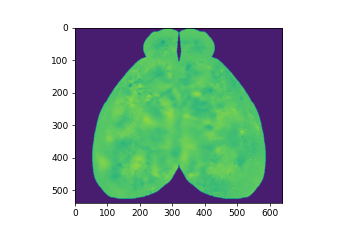

In [184]:
#make sure the atlas and image are in the same atlas space
plt.figure()
alpha=.75
temp_at = atlas != 0
plt.imshow(temp_at/100 * (1.0 - alpha) + stack.U_warped.mean(axis=2) * alpha)


<IPython.core.display.Javascript object>


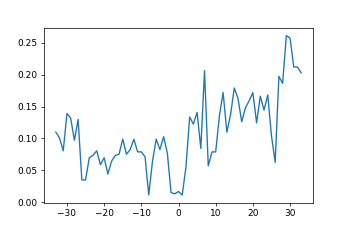

In [185]:
plt.figure()
plt.plot(u_areas,np.max(test_results-shuf_results,axis=0))
plt.show()

<IPython.core.display.Javascript object>


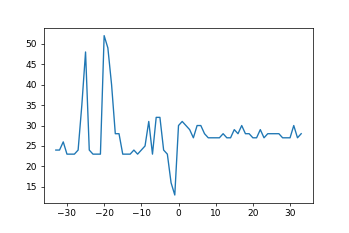

In [186]:
plt.figure()
plt.plot(u_areas,np.argmax(test_results-shuf_results,axis=0))

<IPython.core.display.Javascript object>


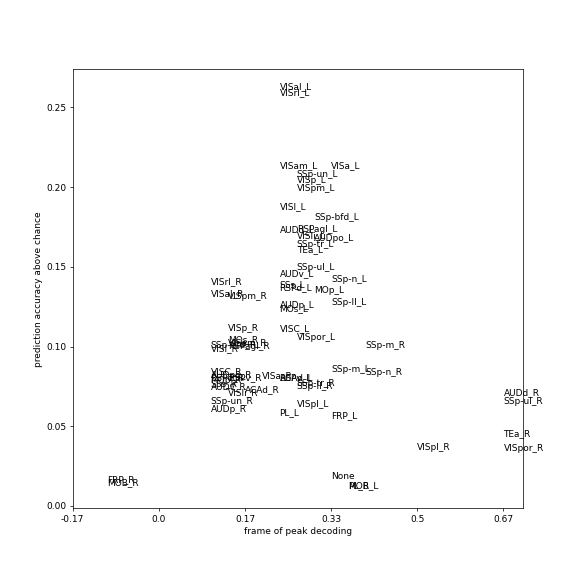

[Text(15, 0, '-0.17'),
 Text(20, 0, '0.0'),
 Text(25, 0, '0.17'),
 Text(30, 0, '0.33'),
 Text(35, 0, '0.5'),
 Text(40, 0, '0.67')]

In [187]:
%matplotlib notebook
pred_power = np.max(test_results-shuf_results,axis=0)
best_frame = np.argmax(test_results-shuf_results,axis=0)
best_frame[best_frame < 17] = 17
best_frame[best_frame > 40] = 40
figure,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(best_frame,pred_power,'.w')
for i in range(len(full_allen_list)):
    
    ax.text(best_frame[i],pred_power[i],full_allen_list[i])
    plt.draw()
ax.set_ylabel('prediction accuracy above chance')
ax.set_xlabel('frame of peak decoding')
ax.set_xticks([15,20,25,30,35,40])
ax.set_xticklabels((np.array([-5,0,5,10,15,20])/30).round(2))

<IPython.core.display.Javascript object>


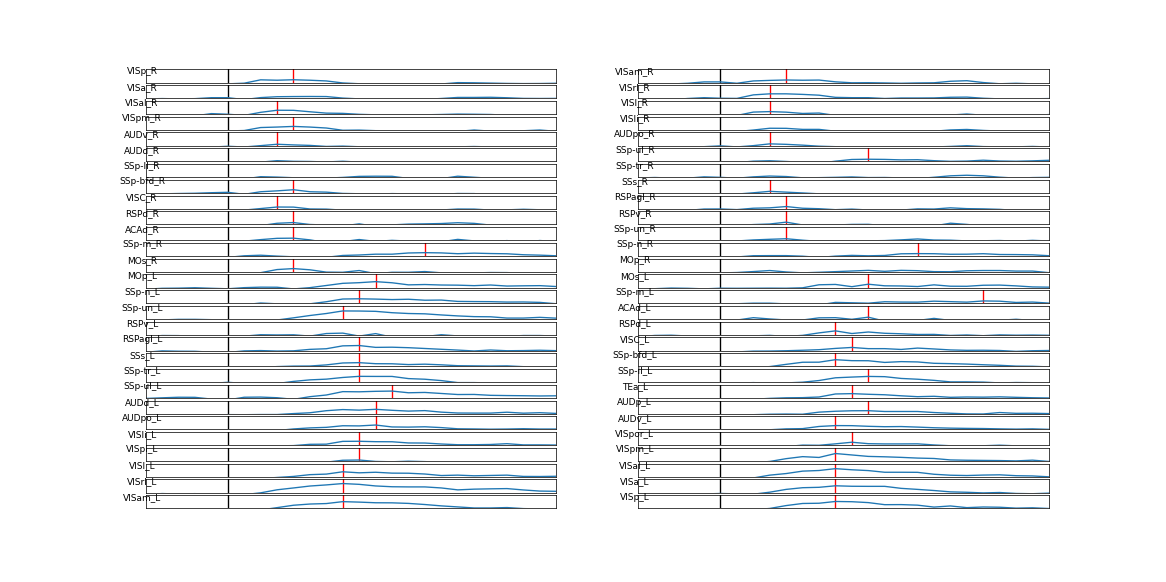

In [189]:
use = pred_power > .06
use_tests = test_results[:,use]
use_shuf = shuf_results[:,use]
use_preds = pred_power[use]
use_names = np.array(full_allen_list)[use]
fig,axs = plt.subplots(int(sum(use)/2),2,figsize = (20,10))
for i in range(len(use_names)):
    ax = axs[int(i/2),i%2]
    ax.axes.xaxis.set_visible(False)
    ax.set_ylabel(use_names[i],rotation=0)
    ax.set_yticks([])
    ax.set_ylim(.5,.8)
    ax.axvline(pre,color='k')
    ax.axvline(np.argmax(use_tests[:,i]),color='r')
    ax.set_xlim(15,40)
    ax.plot(np.arange(pre+post),use_tests[:,i])

In [242]:
### fit the log regression for training data, need to do this for each area independently,
from sklearn.model_selection import KFold
K = 5
kf = KFold(K)
kf.get_n_splits(Ys)
C=200
test_results = np.zeros((K,len(u_areas)))
coefs = np.zeros((K,len(u_areas),pre+post))
cnt = 0
for area in tqdm(u_areas):
    area_mask = u_areas==area
    k=0
    for train,test in kf.split(Ys):
        train_X, test_X = Xs[:,train,:],Xs[:,test,:]
        train_Y, test_Y = Ys[train],Ys[test]
        model = LogisticRegression(C=C,solver='liblinear',max_iter=100000,penalty='l2')
        model.fit(np.squeeze(train_X[:,:,area_mask]).T,train_Y)
        prediction = model.predict(np.squeeze(test_X[:,:,area_mask]).T)
        test_results[k,cnt] = np.mean(prediction == test_Y)
        coefs[k,cnt,:] = model.coef_
        k+=1
    cnt+=1

test_SD = test_results.std(axis=0)
test_results = test_results.mean(axis=0)
coefs=coefs.mean(axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:06<00:00, 10.74it/s]


In [234]:
np.mean(test_results)

0.6111177224801763

<IPython.core.display.Javascript object>


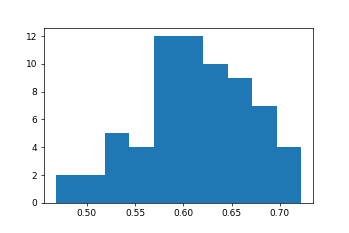

(array([ 2.,  2.,  5.,  4., 12., 12., 10.,  9.,  7.,  4.]),
 array([0.46807339, 0.49347289, 0.51887239, 0.54427189, 0.56967139,
        0.59507089, 0.62047039, 0.64586989, 0.67126939, 0.69666889,
        0.72206839]),
 <BarContainer object of 10 artists>)

In [235]:
plt.figure()
plt.hist(test_results)

<IPython.core.display.Javascript object>


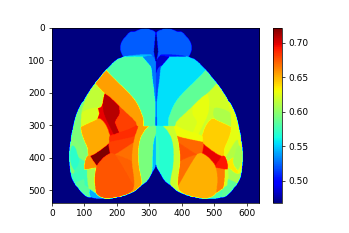

In [238]:
pred_im = np.copy(atlas)
cnt=0
for i in np.unique(atlas):
    pred_im[pred_im==i] = test_results[cnt]
    cnt+=1
plt.figure()
plt.imshow(pred_im,cmap='jet')
plt.colorbar()

<IPython.core.display.Javascript object>


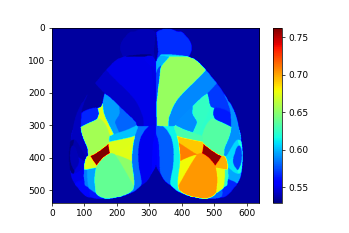

In [243]:
pred_im = np.copy(atlas)
cnt=0
for i in np.unique(atlas):
    pred_im[pred_im==i] = test_results[cnt]
    cnt+=1
plt.figure()
plt.imshow(pred_im,cmap='jet')
plt.colorbar()

<IPython.core.display.Javascript object>


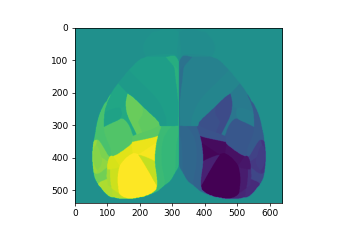

In [248]:
plt.figure()
at_im = atlas.copy()
at_im[atlas==13]=0
plt.imshow(at_im)

In [245]:
ccf_regions[['acronym','label']]

,acronym,label
0,MOB,1
1,FRP,2
2,MOp,3
3,MOs,4
4,SSp-n,5
5,SSp-m,6
6,SSp-un,7
7,PL,8
8,ACAd,9
9,RSPv,10
